<h2>Importing tensorflow and other libraries</h2>

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf

from tensorflow.keras.applications import *
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

<h2>Setup datset</h2>

In [6]:
data_dir = './maize_photos'
data_dir = pathlib.Path(data_dir)

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4187


In [37]:
blight = list(data_dir.glob('Blight/*'))
common_rust = list(data_dir.glob('Common_Rust/*'))
gray_leaf_spot = list(data_dir.glob('Gray_Leaf_Spot/*'))
healthy = list(data_dir.glob('Healthy/*'))

<h2>Load using keras.preprocessing</h2>

<h3>Create a dataset</h3>

In [13]:
batch_size = 32
img_height = 180
img_width = 180

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4188 files belonging to 4 classes.
Using 3351 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4188 files belonging to 4 classes.
Using 837 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


<h3>Visualize the data</h3>

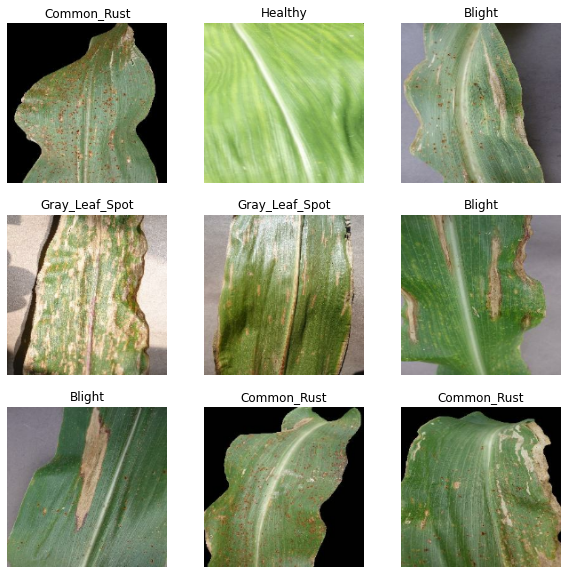

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


<h3>Configure the dataset for performance</h3>

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<h3>Standardize the data</h3>

In [22]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.08791427 0.9812313


<h2>Create the model</h2>

In [31]:
num_classes = 4

conv_base = EfficientNetB0(weights="imagenet", include_top=False)

model = Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))

#avoid overfitting
model.add(layers.Dropout(rate=0.2, name="dropout_out"))

# Set NUMBER_OF_CLASSES to the number of your final predictions.
model.add(layers.Dense(4, activation="softmax", name="fc_out"))
conv_base.trainable = False

<h3>Compile the model</h3>

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<h3>Model Summary</h3>

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 4)                 5124      
Total params: 4,054,695
Trainable params: 5,124
Non-trainable params: 4,049,571
_________________________________________________________________


<h3>Train the model</h3>

In [35]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
105/105 [==============================] - 83s 749ms/step - loss: 1.2671 - accuracy: 0.6204 - val_loss: 0.3175 - val_accuracy: 0.8829
Epoch 2/10
105/105 [==============================] - 76s 721ms/step - loss: 0.3797 - accuracy: 0.8737 - val_loss: 0.2823 - val_accuracy: 0.9044
Epoch 3/10
105/105 [==============================] - 76s 722ms/step - loss: 0.3152 - accuracy: 0.8959 - val_loss: 0.2323 - val_accuracy: 0.9200
Epoch 4/10
105/105 [==============================] - 75s 716ms/step - loss: 0.2580 - accuracy: 0.9052 - val_loss: 0.2328 - val_accuracy: 0.9223
Epoch 5/10
105/105 [==============================] - 76s 723ms/step - loss: 0.2396 - accuracy: 0.9166 - val_loss: 0.2248 - val_accuracy: 0.9283
Epoch 6/10
105/105 [==============================] - 77s 734ms/step - loss: 0.2213 - accuracy: 0.9135 - val_loss: 0.2123 - val_accuracy: 0.9271
Epoch 7/10
105/105 [==============================] - 76s 725ms/step - loss: 0.1830 - accuracy: 0.9340 - val_loss: 0.2105 - val_ac

<h2>Predict new Data</h2>

In [48]:
img_path = './test/test_1.jpg'
img = keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Gray_Leaf_Spot with a 28.93 percent confidence.
